<a href="https://colab.research.google.com/github/ngzhankang/Deep-Learning/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1
Submitted by : P1935727 Ng Zhan Kang<br>
Class of DIT/FT/2B/11


---
---

# 1.Setting Up Working Environment In Google Colab

### 1.1 Ensuring 0% Util

---

Ensure that our slot give by Google is not utilized yet.

In [1]:
# to ensure that the current gpu utilization is 0
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize

import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 12.8 GB  | Proc size: 112.1 MB
GPU RAM Free: 15079MB | Used: 0MB | Util   0% | Total 15079MB


### 1.2. Forcing Utils To 0% To Get A Clean Cluster

---

Please do not use this step unless the cluster you are allocated to is quite full.

In [2]:
## if utilization is > 0, run this code(keep running this cell and the above cell till the util number is 0%):
## NOTE THAT RUNNING THIS MIGHT KILL GPU SESSION AND RESULT IN DATA LOSS(NOT ADVICABLE TO KEEP ON REUSING)
# !kill -9 -1

---
---

# 2.Ensuring GPU Is Utilized In Environment

### 2.1. See the list of available devices

---

This entire section can be omitted if users are not utilizing GPU at all.

In [3]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14045811423720119625
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15205296039293721076
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5209889912386189181
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14640891840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 135255253479811280
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [6]:
!nvidia-smi

Thu Nov 26 05:50:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    30W /  70W |    227MiB / 15079MiB |      8%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

---
---

# 3.Background Information

## 3.1. About The MNIST Dataset
---

- BACKGROUND
  - The MNIST database of handwritten digits(Modified National Institute of Standards and Technology database) history came to existence in the late 1980s.
  - Also known as a "Hello World" exercise for people new to Neural Networks (or deep learning).
  - Was an extension of the NIST database, which the training dataset were handwriting originating from American Census Bureau employees, while the test dataset were handwriting taken from American high school students, also known as Special Dataset 3 and Special Dataset 1 respectively.
  - The creators of this dataset are **Yann LeCun, Corinna Cortes and Christopher J.C. Burges**.
  - The creators felt that NIST datasets was not well-suited for machine learning experiments since the origins of the train and test datasets **came from 2 different groups in the aforementioned point**. Furthermore, the black and white images from NIST were **normalized to fit into a 28 X 28 pixel bounding box and anti-aliased**, which introduced grayscale levels.
  - Contains **60,000 training and 10,000 testing images**. Half of the training set and half of the test set were taken from NIST's training dataset, while the other half of the training set and the other half of the test set were taken from NIST's testing dataset.
  - Initially used **Support-Vector Machine** to get an error rate of 0.8%.
  - Was popular to build new government applications, including the US Department Of Defence, which wants to build an Automated Target Recognition (ATR) and also on the civilian side, from the postal service and IRAS to build an automated process of recognising handwritings for postcodes and others.


- BEST PERFORMANCES RECORDED
  - The current best record was made in 2018, by researches from Department of System and Information Engineering, University Of Virginia, which announced 0.18% error with simultaneous stacked three kind of neural networks (fully connected, recurrent and convolutional neural networks).
  - The original record as per written in [the MNIST dataset main website](http://yann.lecun.com/exdb/mnist/), was a test error rate of 12%, using 1 layer of linear classifier without any preprocessing at all.


- ARCHITECTURES
  - A notable deep neural network, called convolutional neural network, is a regularized version of multilayer perceptrons. It is one notable image classification algorithm, as it learns the filters, which traditionally were hand-engineered.
  - There are many architectures that make use of the basic CNN architecture and then improve on it. Examples are Neocognitron, the origin of CNN architecture, Time delay neural networks and CNN trained by gradient descent.
  - LeNet-5, or LeNet is also a architecture that originate from Yann LeCun. It is originally a system to recognise hand-written ZIP Code numbers involved convolutions in which the kernel coefficients had been laboriously hand designed. It usese a 7-level convolutional network that classifies digits, was applied by several banks to recognize hand-written numbers on cheques, digitized in 32x32 pixel images.

  - VGGNet was invented by VGG (Visual Geometry Group) from the University Of Oxford. It was a neural network which has proven significant improvement over ZFNet and AlexNet. It was one of the deep learning models that obtained less than 10% of error rate. It was trained on ImageNet dataset, a large dataset of annotated photographs intended for computer vision research. Pictures include cars, plant, flora, plant life, fungus, animal, etc. It have been proven effective for object recognition, but does not work properly for scenes recognition. Also, it uses alot of memory and is computationally time consuming.

  - AlexNet was primarily designed by Alex Krizhevsky, and was published with Ilya Sutskever and Krizhevsky's doctoral advisor Geoffrey Hinton, and is a Convolutional Neural Network or CNN. It achieved a top-5 error of 15.3% after competing in ImageNet Large Scale Visual Recognition Challenge, which was 10.8% lower than that of the runner up. It also, just like VGGNet, was trained on ImageNet dataset, and is meant for object recognition.


- GRAPHICAL IMAGE

  <img src="https://files.ifi.uzh.ch/ddis/teaching/bda/tensorflow_keras/img/mlp_1.png" alt="Graphical Image Of CNN with MNIST Dataset" title="MNIST database multilayer perceptron" />

## 3.2. Classic MNIST Dataset
---

- For this problem, create a CNN for image classification and evaluate the performance of the network
- Prepare the data and perform necessary feature engineering
- Create **_three models_**, which the scores should differ from one another significantly.
- Record down insights and reasonings.
- Form some conclusions.

---
---

# 4.Data Importing

### 4.1. Load the libraries

---

Import the necessary libraries.

In [7]:
# Suppress Future Warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
# check versions of libraries we are going to use
%tensorflow_version 2.x
import os
import tensorflow
import sklearn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import platform

message="        Versions        "
print("*"*len(message))
print(message)
print("*"*len(message))
print("Tensorflow version={}".format(tensorflow.__version__))
print("Keras version={}".format(tensorflow.keras.__version__))
print("Sklearn version={}".format(sklearn.__version__))
print("Numpy version={}".format(np.__version__))
print("Pandas version={}".format(pd.__version__))
print("Seaborn version={}".format(sns.__version__))
print("Matplotlib version={}".format(matplotlib.__version__))
print("Python version={}".format(platform.python_version()))

************************
        Versions        
************************
Tensorflow version=2.3.0
Keras version=2.4.0
Sklearn version=0.22.2.post1
Numpy version=1.18.5
Pandas version=1.1.4
Seaborn version=0.11.0
Matplotlib version=3.2.2
Python version=3.6.9


In [9]:
# download the necessary libraries that is not inside keras library
!pip install keras-adabound
!pip install keras-tuner

# start importing necessary libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, AveragePooling2D, Activation, BatchNormalization, MaxPooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, History
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from keras_adabound import AdaBound

import kerastuner as kt
from kerastuner.tuners import Hyperband
from kerastuner import HyperModel

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import itertools

%matplotlib inline

In [10]:
# fix random seed for reproducibility
np.random.seed(5)

In [11]:
# get the dataset from keras library in tensorflow 2.0
mnist = tf.keras.datasets.mnist

# unpack the dataset to the respective x_train, y_train, x_test and y_test
(x_train, y_train), (x_test, y_test) = mnist.load_data()

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> MNIST Dataset includes handwritten digits from 0 to 9, and dimensions are 28 by 28 pixels. Each pixels is 8 bits, so its value ranges from to 0 to 255.
</div>

### 4.2. Verify the dataset

---

Verify the credibility of the dataset first by plotting the 1st 25 images from the training set and display the class name below each image.

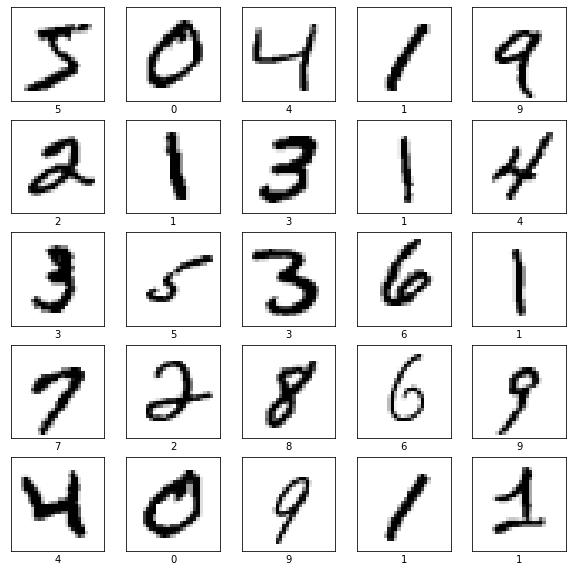

In [12]:
# plot out some handwritings out so that we can see
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i], color="black")
plt.show()

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> It seems that the labels matches all the images, which is good! Now let's carry on to get a better insight of the datatset we are going to deal with.
</div>

---
---

# 5.Exploratory Data Analysis

### 5.1. Basic Data Exploration

---

Take a peek look at what is inside the `x_train` and the `x_test`.

In [13]:
# take a look at the x_train set first
print(x_train.shape)
print(y_train.shape)

(60000, 28, 28)
(60000,)


In [14]:
# take a look at the x_test set
print(x_test.shape)
print(y_test.shape)

(10000, 28, 28)
(10000,)


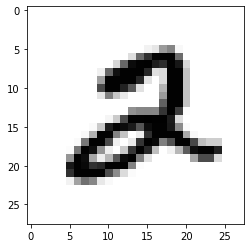

In [15]:
# grab a random picture to take a look
plt.imshow(x_train[5], cmap=plt.cm.binary)
plt.show()

In [16]:
# get the distinct lables that are found in the entire thing
print('Training set unique labels:',np.unique(y_train))
print('Test set unique labels:',np.unique(y_test))

Training set unique labels: [0 1 2 3 4 5 6 7 8 9]
Test set unique labels: [0 1 2 3 4 5 6 7 8 9]


In [17]:
# get the count of the values from 0 to 9
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   0 5923]
 [   1 6742]
 [   2 5958]
 [   3 6131]
 [   4 5842]
 [   5 5421]
 [   6 5918]
 [   7 6265]
 [   8 5851]
 [   9 5949]]


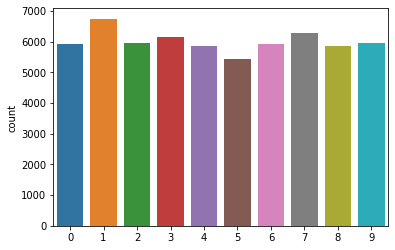

In [18]:
# countplot for each digits
g = sns.countplot(y_train)

Text(0.5, 1.0, 'Pixel Value Distribution')

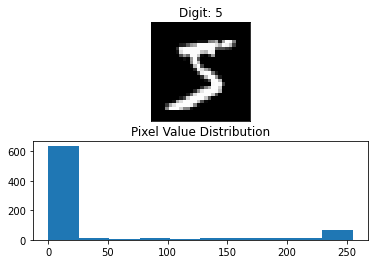

In [19]:
# get the distribution of our pixel values
fig = plt.figure()
plt.subplot(2,1,1)
plt.imshow(x_train[0], cmap='gray', interpolation='none')
plt.title("Digit: {}".format(y_train[0]))
plt.xticks([])
plt.yticks([])

plt.subplot(2,1,2)
plt.hist(x_train[0].reshape(784))
plt.title("Pixel Value Distribution")

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> From what we can see, the pixel values ranges from 0 to 255, with the majority close to 0, and those close to 255 respresenting the digit.
</div>

---
---

# 6.Feature Engineering

### 6.1. Changing Dimension To Match Keras Expectation

---

Reshape `x_train` and `x_test` to 4 dimensional array for the convolutional layer later on.

In [20]:
# flatten 28*28 pixel images to 784 pixels for each image(from a 2D array to a 1D array)
num_pixels = x_train.shape[1] * x_train.shape[2]
X_train = x_train.reshape(x_train.shape[0], num_pixels).astype('float32')
X_test = x_test.reshape(x_test.shape[0], num_pixels).astype('float32')

# see the changes
print('New X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

New X_train shape: (60000, 784)
60000 train samples
10000 test samples


### 6.2. Normalize Training Data

---

Normalize the entire training dataset so that there is not much variation.

In [21]:
# attempt to normalize the entire dataset first from 0-255 to 0-1
X_train /= 255
X_test /= 255

# see the shape of x_train and x_test first
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

X_train shape: (60000, 784)
X_test shape: (10000, 784)
60000 train samples
10000 test samples


### 6.3. Convert To Categorical Data

---

Convert the labels to categorical data as we do not want the model to think 9 has a higher priority than 0.

In [22]:
# use to_categorical to convert the training and testing dataset labels
num_classes = 10 # number of classes (numbers 0 to 9)

Y_train = tf.keras.utils.to_categorical(y_train, num_classes)
Y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# now lets check again the training and test dataset labels
print('Y_train:', Y_train[0])
print('Y_test:', Y_test[0])

Y_train: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Y_test: [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


### 6.4. Transforming to 1D array

---

We will change the numpy array to a 1D array so that we can feed inside our MLP models.

In [23]:
# we are going to retain the original 1D shape and put in a new variable so that we will not mess up with the others
X_train_MLP = X_train
X_test_MLP = X_test

# examine the shape before we feed it in
print('New X_train_MLP shape:', X_train_MLP.shape)
print(X_train_MLP.shape[0], 'train samples')
print(X_test_MLP.shape[0], 'test samples')

New X_train_MLP shape: (60000, 784)
60000 train samples
10000 test samples


### 6.5. Transforming to 2D array

---

We will change the numpy array to a 2D array so that we can feed inside our CNN models.

In [24]:
# reshape x_train and x_test to (n_images, x_shape, y_shape, channels)
# we are going to make chanels be 1 as we are not dealing with rgb images.
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

# examine the shape before we feed it in
print('New X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

New X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


---
---

# 7.Models

### 7.1. Baseline MLP Model

---

First, we will setup a baseline model using a simple MLP architecture.

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> A simple MLP arcitecture does not have any Convolutional Layers. Here we are just playing around with Dense layers and see how good can the score be with MNIST dataset.
</div>

In [446]:
# create model and give it a name
model = Sequential(name="mlp_baseline_model")

# Layer 1 Fully Connected Layer (Hidden Layer)
model.add(Dense(350, kernel_initializer='normal', activation='relu', input_dim=num_pixels))

# Layer 2 Fully Connected Layer (Hidden Layer)
model.add(Dense(50, kernel_initializer='normal', activation='relu'))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# model summary
model.summary()

Model: "mlp_baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 350)               274750    
_________________________________________________________________
dense_5 (Dense)              (None, 50)                17550     
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
Total params: 292,810
Trainable params: 292,810
Non-trainable params: 0
_________________________________________________________________


In [447]:
# Configure the model and start training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_MLP, Y_train, epochs=10, batch_size=200, verbose=1, validation_split=0.2)

Epoch 1/10
240/240 [==============================] - 1s 4ms/step - loss: 0.3628 - accuracy: 0.8991 - val_loss: 0.1779 - val_accuracy: 0.9480
Epoch 2/10
240/240 [==============================] - 1s 3ms/step - loss: 0.1386 - accuracy: 0.9594 - val_loss: 0.1239 - val_accuracy: 0.9637
Epoch 3/10
240/240 [==============================] - 1s 3ms/step - loss: 0.0915 - accuracy: 0.9727 - val_loss: 0.1037 - val_accuracy: 0.9688
Epoch 4/10
240/240 [==============================] - 1s 3ms/step - loss: 0.0665 - accuracy: 0.9802 - val_loss: 0.0889 - val_accuracy: 0.9742
Epoch 5/10
240/240 [==============================] - 1s 3ms/step - loss: 0.0490 - accuracy: 0.9860 - val_loss: 0.0870 - val_accuracy: 0.9753
Epoch 6/10
240/240 [==============================] - 1s 3ms/step - loss: 0.0371 - accuracy: 0.9892 - val_loss: 0.0858 - val_accuracy: 0.9760
Epoch 7/10
240/240 [==============================] - 1s 3ms/step - loss: 0.0281 - accuracy: 0.9918 - val_loss: 0.0814 - val_accuracy: 0.9768
Epoch 

In [448]:
#print the available history keys for use
print(history.history.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


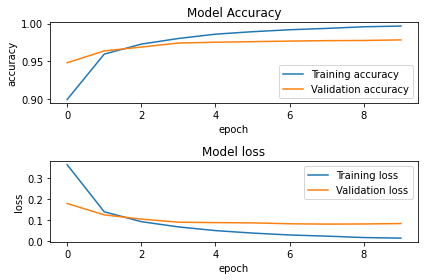

In [449]:
# plotting the accuracy and loss graphs
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='best')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='best')

plt.tight_layout()

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> So from here, we can see that the training loss and validation loss converged around epoch 1, and the training loss is eventually lesser than the validation loss, hinting overfitting. We will not expect much from this arcitecture and we shall move on to see the results and the test accuracy and model loss.
</div>

### 7.2. Baseline CNN Model

---

First, we will setup a baseline model using a simple CNN architecture.

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> Here, we will try to create a simple CNN model, using relu as our activation  functions for all and adam as our optimizer.
</div>

In [519]:
# create model and give it a name
model = Sequential(name="sequential_baseline_model")

# Layer 1 Conv2D
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
# Layer 2 Pooling Layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3 Flatten Layer
model.add(Flatten())

# Layer 4 Fully Connected Layer (Hidden Layer)
model.add(Dense(100, kernel_initializer='he_uniform', activation='relu'))

# Output layer
model.add(Dense(num_classes, activation='softmax'))

# model summary
model.summary()

Model: "sequential_baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 5408)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               540900    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________


In [520]:
# implement a learning rate schedule in keras
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-08

adam = Adam(lr=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

In [521]:
# time to optimise the empty baseline model(an empty shell basically) and fit it with our training dataset
# passing params into the newly created model and compile it
model.compile(optimizer=adam,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# train the model
history = model.fit(X_train, Y_train, validation_split=0.2, epochs=15, batch_size=32, verbose=1)

Epoch 1/15
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1729 - accuracy: 0.9482 - val_loss: 0.0779 - val_accuracy: 0.9771
Epoch 2/15
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0594 - accuracy: 0.9824 - val_loss: 0.0605 - val_accuracy: 0.9815
Epoch 3/15
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0387 - accuracy: 0.9881 - val_loss: 0.0724 - val_accuracy: 0.9788
Epoch 4/15
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0273 - accuracy: 0.9916 - val_loss: 0.0574 - val_accuracy: 0.9844
Epoch 5/15
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0185 - accuracy: 0.9937 - val_loss: 0.0598 - val_accuracy: 0.9842
Epoch 6/15
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0137 - accuracy: 0.9955 - val_loss: 0.0595 - val_accuracy: 0.9845
Epoch 7/15
1500/1500 [==============================] - 4s 3ms/step - loss: 0.0106 - accuracy: 0.9966 - val_loss: 0.0594 - val_accuracy:

In [524]:
#print the available history keys for use
print(history.history.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


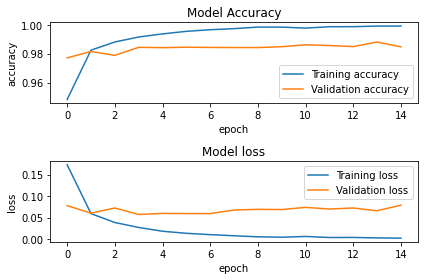

In [525]:
# plotting the accuracy and loss graphs
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='best')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='best')

plt.tight_layout()

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> From here we can see that the training loss and validation loss are not even cconverging at all. The training loss is way lower than the validation loss, a hint of overfitting. Our training accuracy is more accurate than the validation accuracy, which is expected.
</div>

### 7.3. LeNet-5 CNN Model

---

Next, we will setup a CNN Model with abit of changes to the  LeNet-5 architecture.

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> We  understand that there are a few main reasons for overfitting in Neural Networks. They are mainly due to the network size, lack of weight regularization and lack of dropouts. In order to reduce (or to  prevent this from happenening), we will implement these 3 main points. Here we will implement the modified LeNet-5 Architecture to test out how precise the overall architecture is incuding some of the additional features i feel it is important.
</div>

In [414]:
# create model and give it a name
model = Sequential(name="lenet5_cnn_model_sequential")

# Layer 1 Conv2D
model.add(Conv2D(filters=150, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(28, 28, 1), padding='same'))
model.add(BatchNormalization())
# Layer 2 Pooling Layer
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 3 Conv2D
model.add(Conv2D(filters=140, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
model.add(BatchNormalization())
# Layer 4 Pooling Layer
model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

# Layer 5 Flatten
model.add(Flatten())

# Layer 6 Fully Connected Layer (Hidden Layer)
model.add(Dense(units=120, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units=num_classes, activation='softmax'))

# get model summary
model.summary()

Model: "lenet5_cnn_model_sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 28, 28, 150)       3900      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 150)       600       
_________________________________________________________________
average_pooling2d_2 (Average (None, 14, 14, 150)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 10, 10, 140)       525140    
_________________________________________________________________
batch_normalization_3 (Batch (None, 10, 10, 140)       560       
_________________________________________________________________
average_pooling2d_3 (Average (None, 5, 5, 140)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 350

In [415]:
# time to optimise the empty CNN model(an empty shell basically) and fit it with our training dataset
# passing params into the newly created model and compile it
model.compile(optimizer=AdaBound(lr=1e-3, final_lr=0.1),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

# train the model
history = model.fit(X_train,Y_train, validation_split=0.2, batch_size=16, epochs=15, verbose=1)

Epoch 1/15
3000/3000 [==============================] - 23s 8ms/step - loss: 0.1357 - accuracy: 0.9616 - val_loss: 0.0565 - val_accuracy: 0.9844
Epoch 2/15
3000/3000 [==============================] - 23s 8ms/step - loss: 0.0486 - accuracy: 0.9871 - val_loss: 0.0429 - val_accuracy: 0.9883
Epoch 3/15
3000/3000 [==============================] - 22s 7ms/step - loss: 0.0317 - accuracy: 0.9901 - val_loss: 0.0436 - val_accuracy: 0.9881
Epoch 4/15
3000/3000 [==============================] - 22s 7ms/step - loss: 0.0212 - accuracy: 0.9933 - val_loss: 0.0364 - val_accuracy: 0.9910
Epoch 5/15
3000/3000 [==============================] - 22s 7ms/step - loss: 0.0172 - accuracy: 0.9946 - val_loss: 0.0384 - val_accuracy: 0.9912
Epoch 6/15
3000/3000 [==============================] - 22s 7ms/step - loss: 0.0129 - accuracy: 0.9959 - val_loss: 0.0409 - val_accuracy: 0.9913
Epoch 7/15
3000/3000 [==============================] - 22s 7ms/step - loss: 0.0098 - accuracy: 0.9970 - val_loss: 0.0327 - val_ac

In [416]:
#print the available history keys for use
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


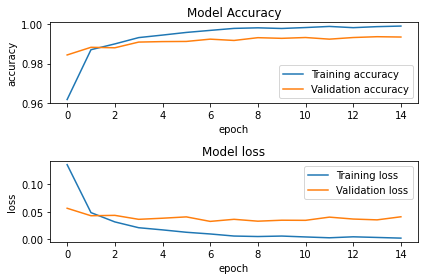

In [417]:
# plotting the accuracy and loss graphs
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='best')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='best')

plt.tight_layout()

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> From what we can see here, the training data and the validation data are not converging at all. This is a sign of overfitting as our training loss is much lesser than the validation loss. We could have plotted out a few more epochs to see if it will converge later or not, but we see that there is not much changes after around 6 epochs, and therefore, we dropped that idea. We will try to add in more penalizers and modify the code more to reduce overfitting.
</div>

### 7.4. LeNet-5 CNN Hyper-Parameter Tuned Model

---

Next, we will setup a LeNet-5 CNN Hyper Parameter Tuned Model that has undergone hyper-parameter tuning.

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> Now from our previous model, it seems that the accuracy score is around 99%, and the model loss is now less than 1%, which is a good indicator that it is a good architecture. We will try to use SGD here as our optimizer. Firstly, we will do a HyperBand, a "twin" of randomsearch to get the best parameter for the weight initializer. After we get the results, we will then proceed on to fit into the model. In the process, i will use HyperBand to tune the hyperparameter.
</div>

In [25]:
# create a hypermodel class to do randomsearch wif kerastuner
class CNNHyperModel(HyperModel):
  def __init__(self, input_shape, num_classes):
    self.input_shape = input_shape
    self.num_classes = num_classes

  def build(self, hp):
    # Instantiate a Sequential model
    model = Sequential()

    # Layer 1 Conv2D
    model.add(Conv2D(filters=150, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=self.input_shape, padding='same'))
    model.add(BatchNormalization())
    # Layer 2 Pooling Layer
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Layer 3 Conv2D
    model.add(Conv2D(filters=140, kernel_size=(5, 5), strides=(1, 1), activation='relu', padding='valid'))
    model.add(BatchNormalization())
    # Layer 4 Pooling Layer
    model.add(AveragePooling2D(pool_size=(2, 2), strides=(2, 2)))

    # Layer 5 Flatten
    model.add(Flatten())

    # Layer 6 Fully Connected Layer (Hidden Layer)
    model.add(Dense(units=120, 
                    activation='relu',
                    kernel_initializer=hp.Choice(
                        'dense_kernel_initalizer',
                        values=['uniform','normal','glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
                        default='glorot_uniform'
                    )))
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(units=self.num_classes, activation='softmax'))

    # passing params into the newly created model and compile it
    model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    
    return model

In [26]:
# put in the input shape and the number of classes
hypermodel = CNNHyperModel(input_shape=(28, 28, 1), num_classes=num_classes)

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> We have to declare our directory and project_name for kerastuner to save all the checkpoints at. We will also initiate our HyperBand here after compiling our model.
</div>

In [28]:
# call yur hyperparameter tuning method
tuner = Hyperband(
    hypermodel,
    max_epochs=60,
    objective='val_accuracy',
    executions_per_trial=2,
    directory='.',
    project_name='hyperparam_cnn'
)

In [29]:
# see the hyperparam to change
tuner.search_space_summary()

Search space summary
Default search space size: 1
dense_kernel_initalizer (Choice)
{'default': 'glorot_uniform', 'conditions': [], 'values': ['uniform', 'normal', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'], 'ordered': False}


<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> Here, we can see that our search space are the values, and they are not ordered. 'glorot_uniform' is the default and it will change as the model search for the best param.
</div>

In [30]:
# declare decay_rate and learning_rate here
learning_rate = 0.1 
decay_rate = 0.1

# define the learning rate change 
def exp_decay(epoch):
    lrate = learning_rate * np.exp(-decay_rate*epoch)
    return lrate
    
# learning schedule callback
lr_rate = LearningRateScheduler(exp_decay)
callbacks_list = [lr_rate]

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> We initiate a learning rate here so that our model training is smoother and that it will change the learning rate during training.
</div>

In [31]:
# start the tuning
tuner.search(X_train, Y_train, epochs=30, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', patience=5), callbacks_list])

Trial 6 Complete [00h 00m 58s]
val_accuracy: 0.9900000095367432

Best val_accuracy So Far: 0.9906249940395355
Total elapsed time: 00h 05m 57s
INFO:tensorflow:Oracle triggered exit


<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> Once its jobs is done, it will trigger exit and not proceed on to test out more.
</div>

In [32]:
# Show a summary of the search
tuner.results_summary()

Results summary
Results in ./hyperparam_cnn
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
dense_kernel_initalizer: glorot_uniform
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.9906249940395355
Trial summary
Hyperparameters:
dense_kernel_initalizer: uniform
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.9900000095367432
Trial summary
Hyperparameters:
dense_kernel_initalizer: he_uniform
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.9897083342075348
Trial summary
Hyperparameters:
dense_kernel_initalizer: glorot_normal
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.9886666536331177
Trial summary
Hyperparameters:
dense_kernel_initalizer: normal
tuner/epochs: 3
tuner/initial_epoch: 0
tuner/bracket: 3
tuner/round: 0
Score: 0.9880416691303253
Trial summary
Hyperparameters:
dense_kernel_initalizer: he_normal

In [33]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

In [34]:
# retrain the model with the optimal hyperparam search
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> From here, we can see that the best weight initializer is he_uniform with an accuracy score of 0.9896250069141388. So what we shall do right now is to use that initializer and refit it into a new model as we cannot use that to evaluate our loss and accuracy using the keras evaluate method. Here, we shall also go and use our ImageDataGenerator and see if we can improve the loss and accuracy score.
</div>

In [35]:
# we shall do some ImageDataGenerator here to augment the input data, which can help prevent over-fitting as we augment the images
datagen = ImageDataGenerator(
    rotation_range=8,
    shear_range=0.3,
    zoom_range=0.08,
    width_shift_range=0.08,
    height_shift_range=0.08,
    rescale=1.1
)

In [36]:
# fit the generator to the data first before training
datagen.fit(X_train)

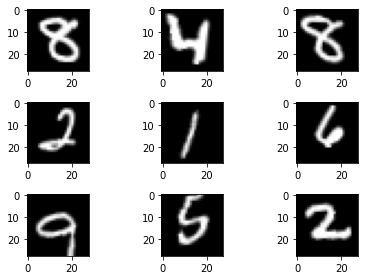

In [37]:
# preview our augmented images here
for X_batch, Y_batch in datagen.flow(X_train, Y_train, batch_size=60000):
  for i in range(0, 9):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_batch[i].reshape(28, 28), cmap=('gray'))
  plt.tight_layout()
  plt.show()
  break

# concatenate the augmented data into a numpy array
augmented_data_X_train = np.concatenate((X_train, X_batch))
augmented_data_Y_train = np.concatenate((Y_train, Y_batch))

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> From here, we add in the new generated digits and concat them with the training dataset.
</div>

In [38]:
# train the model(we use .fit since .fit_generator is depreciated already)
history = model.fit(augmented_data_X_train,
                    augmented_data_Y_train,
                    batch_size=640,
                    epochs=60,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5), callbacks_list],
                    validation_data=(X_test, Y_test),
                    verbose=1)

Epoch 1/60
188/188 [==============================] - 13s 70ms/step - loss: 0.2974 - accuracy: 0.9141 - val_loss: 2.9543 - val_accuracy: 0.1977
Epoch 2/60
188/188 [==============================] - 13s 68ms/step - loss: 0.0713 - accuracy: 0.9790 - val_loss: 2.5638 - val_accuracy: 0.2338
Epoch 3/60
188/188 [==============================] - 13s 69ms/step - loss: 0.0498 - accuracy: 0.9850 - val_loss: 0.3540 - val_accuracy: 0.8675
Epoch 4/60
188/188 [==============================] - 13s 69ms/step - loss: 0.0395 - accuracy: 0.9878 - val_loss: 0.0282 - val_accuracy: 0.9921
Epoch 5/60
188/188 [==============================] - 13s 68ms/step - loss: 0.0335 - accuracy: 0.9900 - val_loss: 0.0241 - val_accuracy: 0.9929
Epoch 6/60
188/188 [==============================] - 13s 68ms/step - loss: 0.0292 - accuracy: 0.9912 - val_loss: 0.0188 - val_accuracy: 0.9929
Epoch 7/60
188/188 [==============================] - 13s 68ms/step - loss: 0.0255 - accuracy: 0.9925 - val_loss: 0.0181 - val_accuracy:

In [42]:
#print the available history keys for use
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


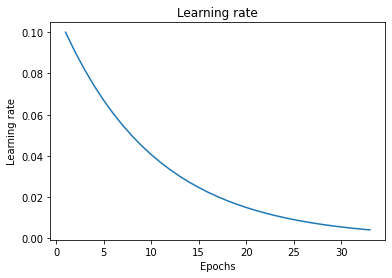

In [43]:
# plot learning rate curve
learning_rate = history.history['lr']
epochs = range(1, len(learning_rate) + 1)
plt.plot(epochs, learning_rate)
plt.title('Learning rate')
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
plt.show()

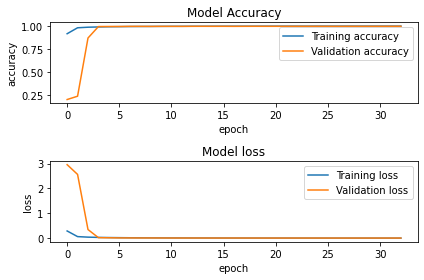

In [44]:
# plotting the accuracy and loss graphs
fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='best')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Training loss', 'Validation loss'], loc='best')

plt.tight_layout()

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> From here, we can see that our training loss and validation loss converge very nicely. This means we have minimized loss effectively.
</div>

---
---

# 8.Test Accuracy, Loss And Results

### 8.1. MLP Baseline Model Result

---

Get the result for the MLP baseline model.

In [450]:
# now we shall evaluate the model and see the accuracy
loss, accuracy = model.evaluate(X_test_MLP,Y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("MLP Baseline Model Accuracy: %.2f%%" % (accuracy*100))
print("MLP Baseline Model Error: %.2f%%" % (100-accuracy*100))

313/313 [==============================] - 1s 2ms/step - loss: 0.0683 - accuracy: 0.9798
Test loss: 0.06834264099597931
Test accuracy: 0.9797999858856201
MLP Baseline Model Accuracy: 97.98%
MLP Baseline Model Error: 2.02%


<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> We can see that our baseline model have a error of 2.02% and accuracy of 97.98%. It is quite impressive that just a MLP arcitecture can already result in such high accuracy. But our test loss is 0.06, and we will try to minimize it.
</div>

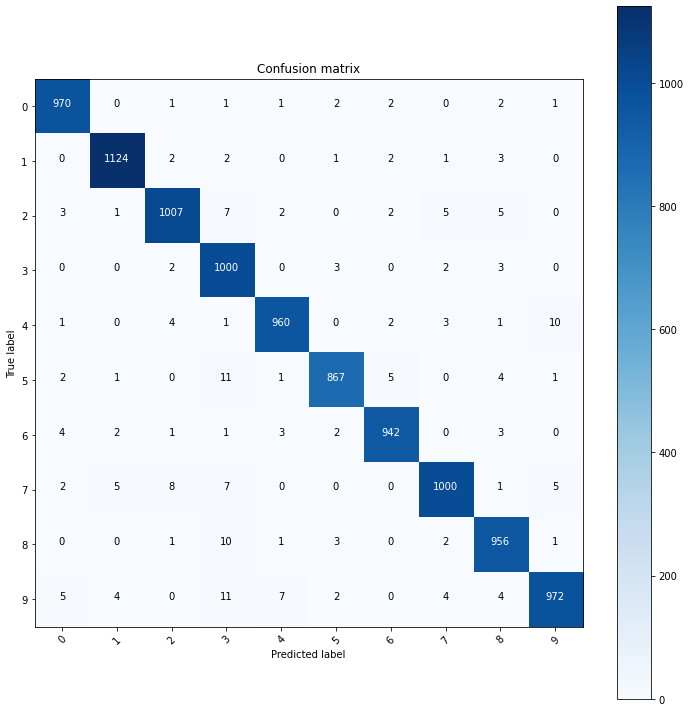

In [451]:
# plot our confusion matrix here to see how many labels got misplaced
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10)) # Set Figure
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test_MLP)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 


9798  classified correctly
202  classified incorrectly


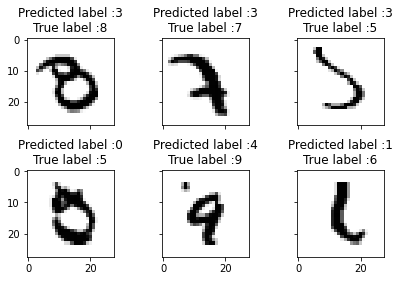

In [452]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_test_MLP[errors]

# see which we predicted correctly and which not
correct_indices = np.nonzero(Y_pred_classes == y_test)[0]
incorrect_indices = np.nonzero(Y_pred_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap=plt.cm.binary)
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.tight_layout()

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> From here, we can see that 5 and 9 have been misclassified as 3, and these 2 are the top errors here. We even have 202 classified incorrectly.
</div>

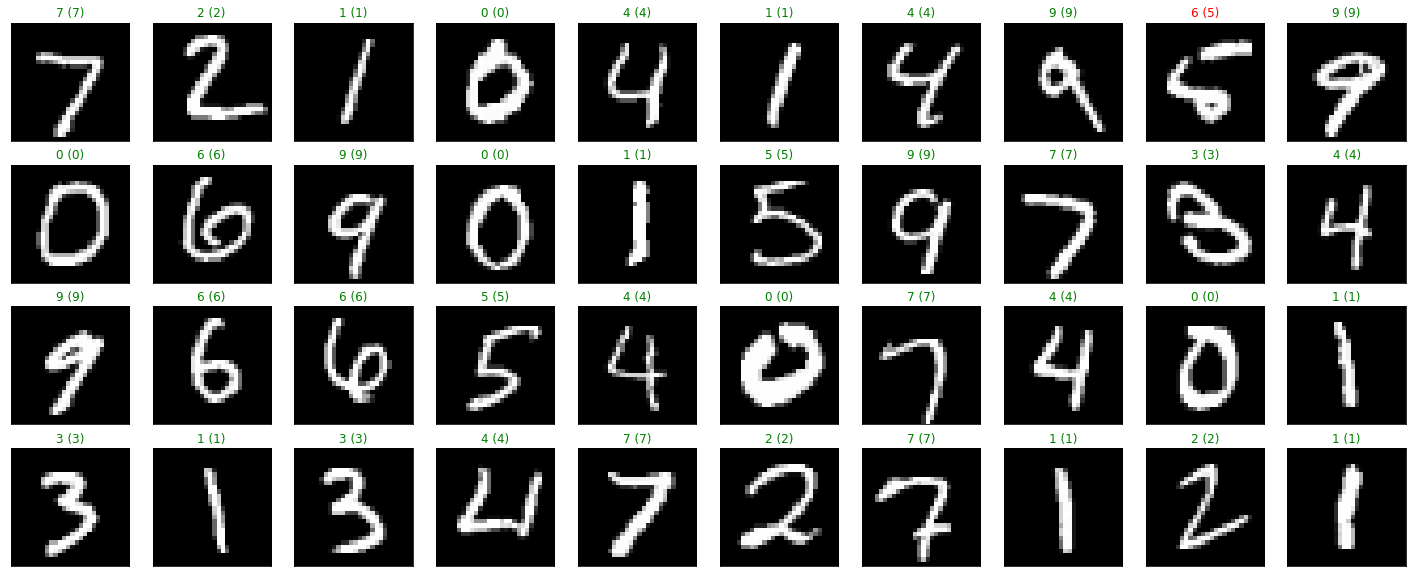

In [ ]:
# obtain 40 test images
images, labels = X_test_MLP[:40], Y_test[:40]

# get sample outputs
predict = model.predict_on_batch(images)
# convert output probabilities to predicted class
preds = np.argmax(predict, axis=1)
labels = np.argmax(labels, axis=1)

# plot the images in the batch, along with predicted and true labels (brackets is true label), non bracket is predicted.
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(40):
    ax = fig.add_subplot(4, 40/4, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].reshape((28, 28)), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx]), str(labels[idx])),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### 8.2. Baseline Model Result

---

Get the result for the baseline model.

In [526]:
# now we shall evaluate the model and see the accuracy
loss, accuracy = model.evaluate(X_test,Y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("Baseline Model Accuracy: %.2f%%" % (accuracy*100))
print("Baseline Model Error: %.2f%%" % (100-accuracy*100))

313/313 [==============================] - 1s 3ms/step - loss: 0.0662 - accuracy: 0.9846
Test loss: 0.06618668138980865
Test accuracy: 0.9846000075340271
Baseline Model Accuracy: 98.46%
Baseline Model Error: 1.54%


<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> From here, we can see that we have a model error score of 1.54% now, an improvement from the previous model. Our test loss, however, is high this time 0.06 although it is a CNN model. But we improved our model accuracy here.
</div>

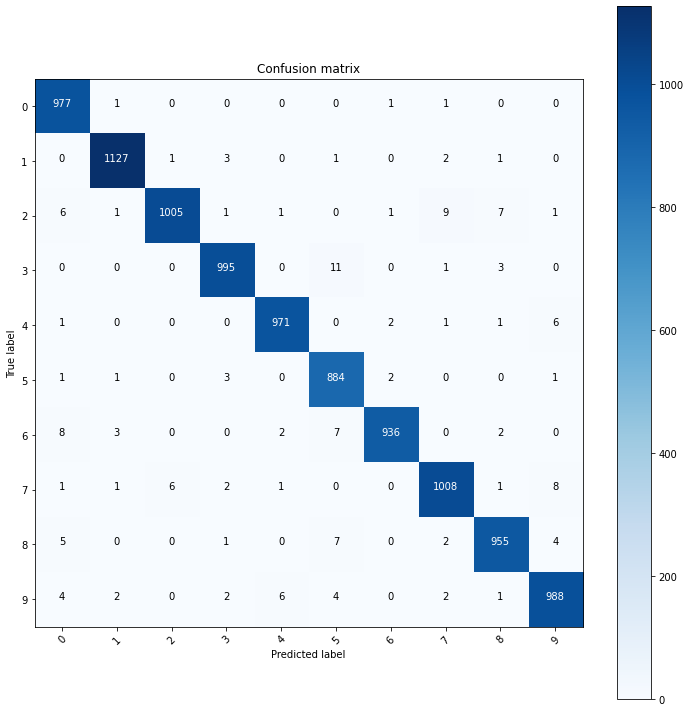

In [527]:
# plot our confusion matrix here to see how many labels got misplaced
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10)) # Set Figure
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 


9846  classified correctly
154  classified incorrectly


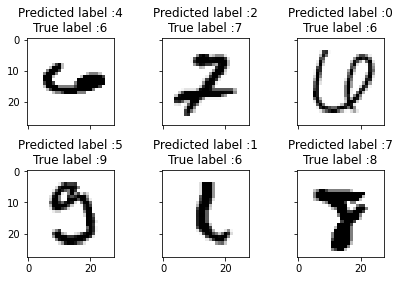

In [528]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_test[errors]

# see which we predicted correctly and which not
correct_indices = np.nonzero(Y_pred_classes == y_test)[0]
incorrect_indices = np.nonzero(Y_pred_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap=plt.cm.binary)
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.tight_layout()

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> From here, 3 has been mostly misclassified as 5 in the confusion matrix. For the top 6 errors, we can see that 4 has been misclassified as 6.
</div>

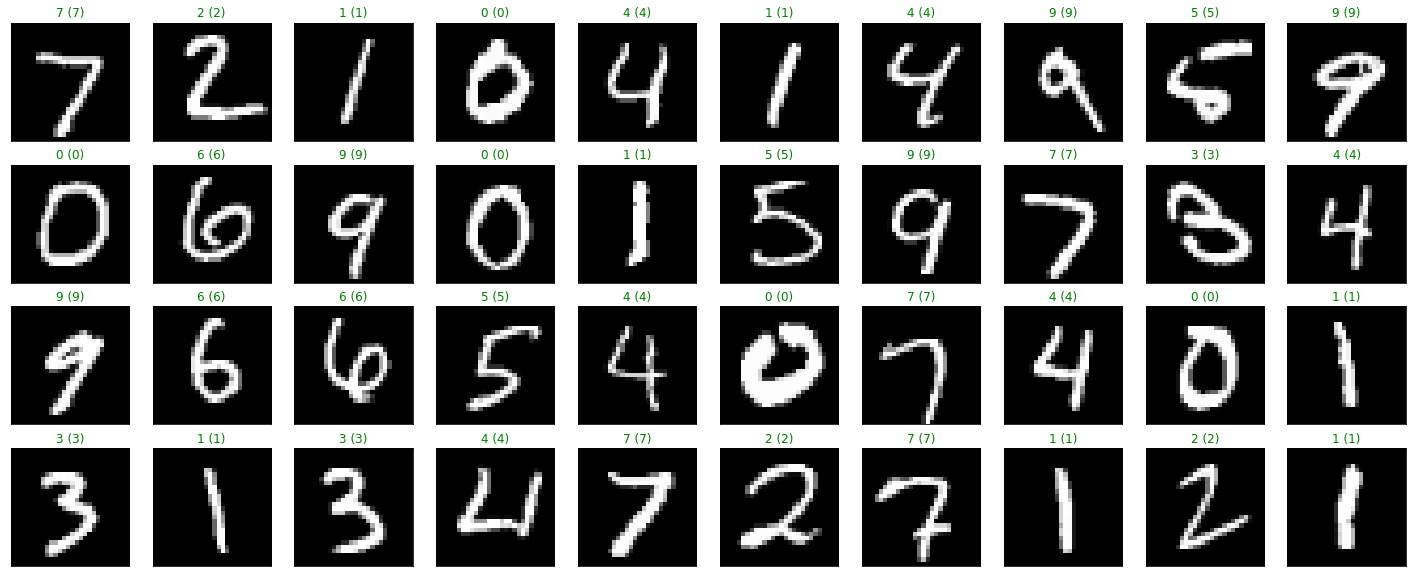

In [529]:
# obtain 40 test images
images, labels = X_test[:40], Y_test[:40]

# get sample outputs
predict = model.predict_on_batch(images)
# convert output probabilities to predicted class
preds = np.argmax(predict, axis=1)
labels = np.argmax(labels, axis=1)

# plot the images in the batch, along with predicted and true labels (brackets is true label), non bracket is predicted.
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(40):
    ax = fig.add_subplot(4, 40/4, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].reshape((28, 28)), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx]), str(labels[idx])),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### 8.3. Standard CNN Model Result

---

Get the result for the CNN model.

In [418]:
# now we shall evaluate the model and see the accuracy
loss, accuracy = model.evaluate(X_test,Y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("CNN Model Accuracy: %.2f%%" % (accuracy*100))
print("CNN Model Error: %.2f%%" % (100-accuracy*100))

313/313 [==============================] - 1s 4ms/step - loss: 0.0290 - accuracy: 0.9941
Test loss: 0.02898314781486988
Test accuracy: 0.9940999746322632
CNN Model Accuracy: 99.41%
CNN Model Error: 0.59%


<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> From here, we have a great improvement not only in test loss, but also the model accuracy and error. We saw a significant drop in the test loss, and our model accuracy got through the 99% mark, with an error rate of around 0.59%.
</div>

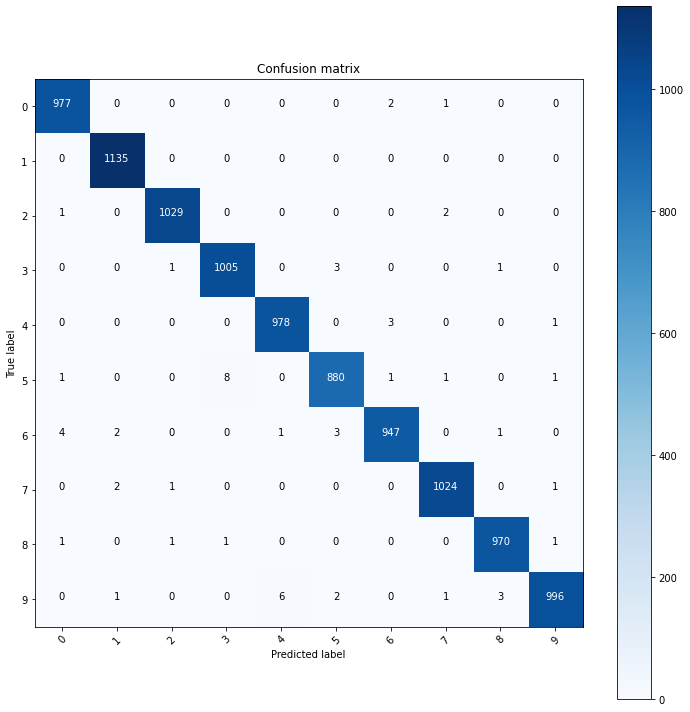

In [419]:
# plot our confusion matrix here to see how many labels got misplaced
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10)) # Set Figure
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 


9941  classified correctly
59  classified incorrectly


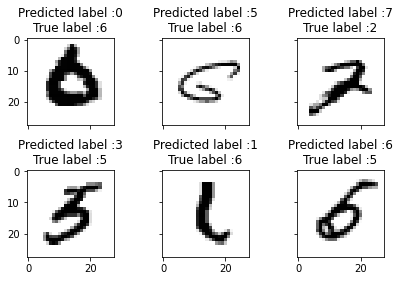

In [420]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_test[errors]

# see which we predicted correctly and which not
correct_indices = np.nonzero(Y_pred_classes == y_test)[0]
incorrect_indices = np.nonzero(Y_pred_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap=plt.cm.binary)
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.tight_layout()

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> From here, we can see that once again, 6 has been predicted wrongly as 1. This is inevitable as the handwritting is really bad. We have 5 misclassified as 3 in the confusion matrix here, with 8 numbers misclassified from that.
</div>

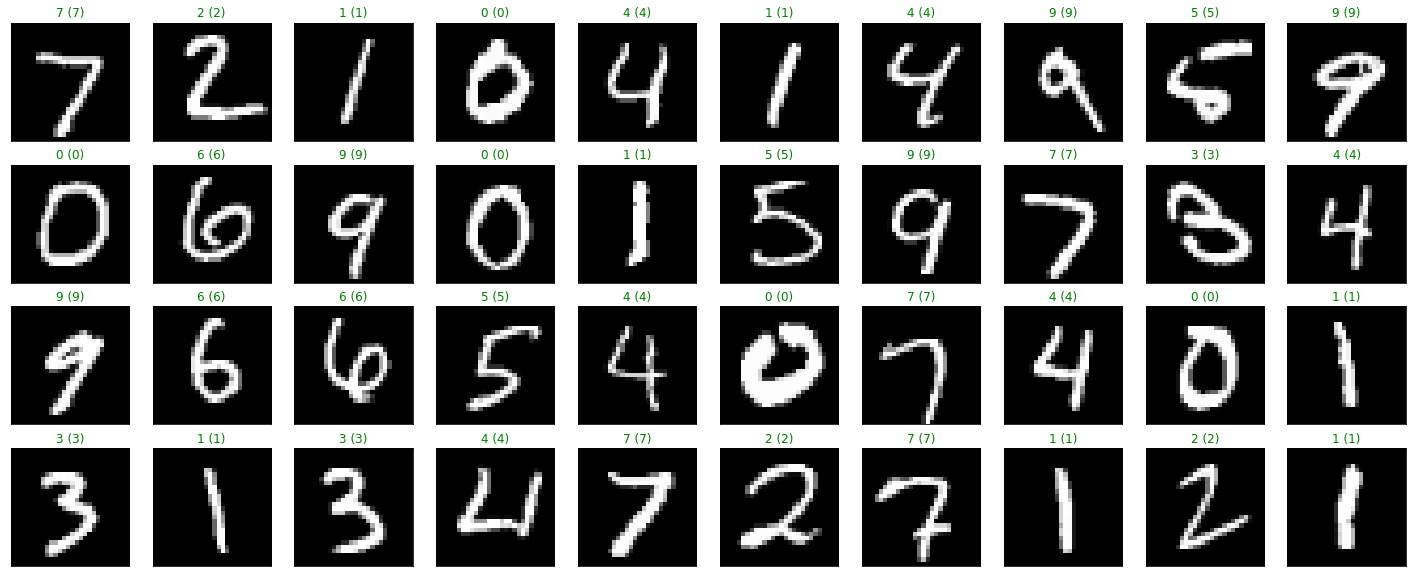

In [421]:
# obtain 40 test images
images, labels = X_test[:40], Y_test[:40]

# get sample outputs
predict = model.predict_on_batch(images)
# convert output probabilities to predicted class
preds = np.argmax(predict, axis=1)
labels = np.argmax(labels, axis=1)

# plot the images in the batch, along with predicted and true labels (brackets is true label), non bracket is predicted.
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(40):
    ax = fig.add_subplot(4, 40/4, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].reshape((28, 28)), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx]), str(labels[idx])),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### 8.4. CNN Hyper-Parameter Tuned Model Result

---

Get the result for the CNN model that has undergone hyper parameter tuning.

In [45]:
# now we shall evaluate the model and see the accuracy(do not use X_val and Y_val)
loss, accuracy = model.evaluate(X_test,Y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)
print("CNN Hyper-Parameter Tuned Model Accuracy: %.2f%%" % (accuracy*100))
print("CNN Hyper-Parameter Tuned Model Error: %.2f%%" % (100-accuracy*100))

313/313 [==============================] - 1s 4ms/step - loss: 0.0132 - accuracy: 0.9952
Test loss: 0.013174046762287617
Test accuracy: 0.995199978351593
CNN Hyper-Parameter Tuned Model Accuracy: 99.52%
CNN Hyper-Parameter Tuned Model Error: 0.48%


<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> From here, we can see that our model has broken the 0.4% model error mark and our model accuracy has slightly improved to 99.52%. Our test loss is all time best, with a score of 0.01, which means we have greatly successfully reduce data loss.
</div>

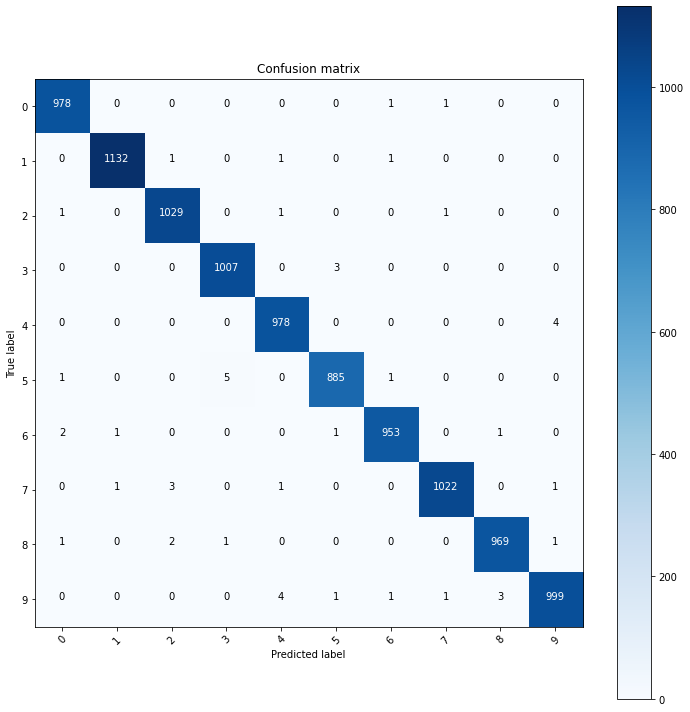

In [46]:
# plot our confusion matrix here to see how many labels got misplaced
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10)) # Set Figure
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10)) 


9952  classified correctly
48  classified incorrectly


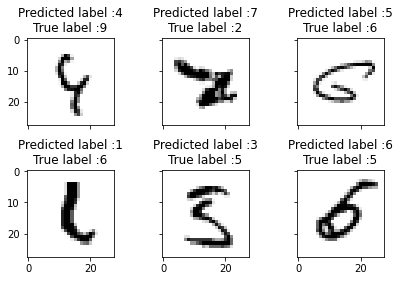

In [47]:
# Display some error results 

# Errors are difference between predicted labels and true labels
errors = (Y_pred_classes - Y_true != 0)

Y_pred_classes_errors = Y_pred_classes[errors]
Y_pred_errors = Y_pred[errors]
Y_true_errors = Y_true[errors]
X_val_errors = X_test[errors]

# see which we predicted correctly and which not
correct_indices = np.nonzero(Y_pred_classes == y_test)[0]
incorrect_indices = np.nonzero(Y_pred_classes != y_test)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")

def display_errors(errors_index,img_errors,pred_errors, obs_errors):
    """ This function shows 6 images with their predicted and real labels"""
    n = 0
    nrows = 2
    ncols = 3
    fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row,col].imshow((img_errors[error]).reshape((28,28)), cmap=plt.cm.binary)
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(pred_errors[error],obs_errors[error]))
            n += 1
    plt.tight_layout()

# Probabilities of the wrong predicted numbers
Y_pred_errors_prob = np.max(Y_pred_errors,axis = 1)

# Predicted probabilities of the true values in the error set
true_prob_errors = np.diagonal(np.take(Y_pred_errors, Y_true_errors, axis=1))

# Difference between the probability of the predicted label and the true label
delta_pred_true_errors = Y_pred_errors_prob - true_prob_errors

# Sorted list of the delta prob errors
sorted_dela_errors = np.argsort(delta_pred_true_errors)

# Top 6 errors 
most_important_errors = sorted_dela_errors[-6:]

# Show the top 6 errors
display_errors(most_important_errors, X_val_errors, Y_pred_classes_errors, Y_true_errors)

<div class="alert alert-block alert-info">
    <b>Analysis Summary:</b> From here, we can see that we 6 has be wrongly predicted as 1, with some images not clear, with 2 predicted wrongly as 7 also.We saw a 5 misclassified as 3 in the confusion matrix, with only 5 digits reported wrongly for that.
</div>

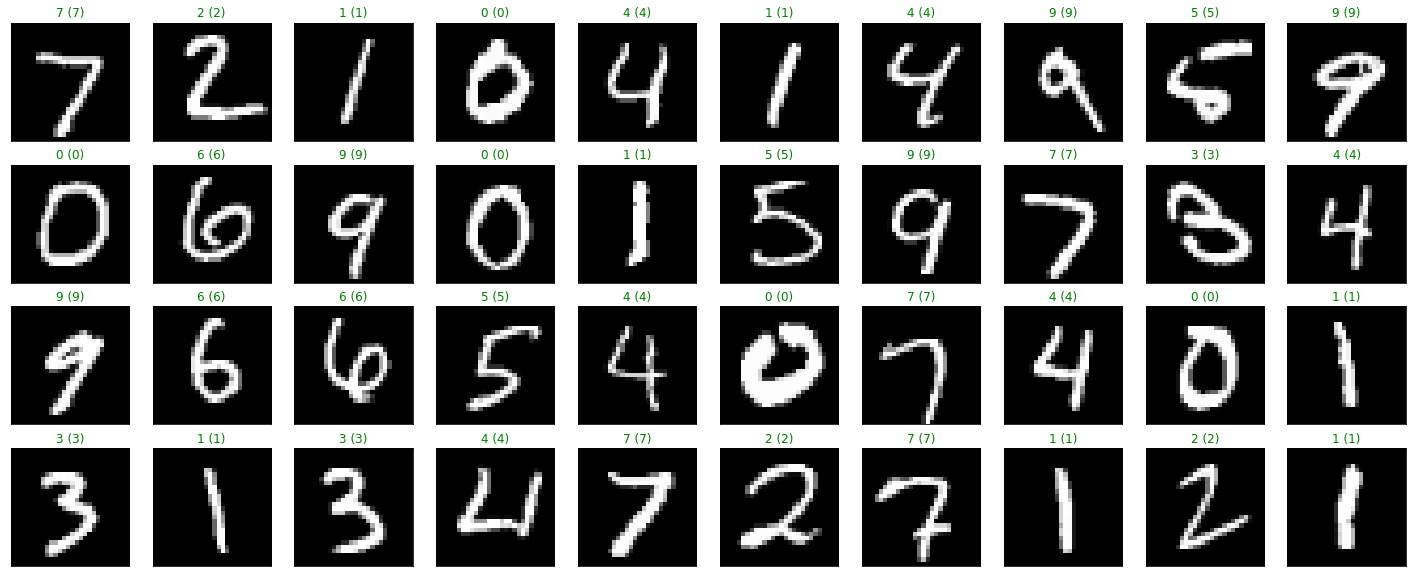

In [48]:
# obtain 40 test images
images, labels = X_test[:40], Y_test[:40]

# get sample outputs
predict = model.predict_on_batch(images)
# convert output probabilities to predicted class
preds = np.argmax(predict, axis=1)
labels = np.argmax(labels, axis=1)

# plot the images in the batch, along with predicted and true labels (brackets is true label), non bracket is predicted.
fig = plt.figure(figsize=(25, 10))
for idx in np.arange(40):
    ax = fig.add_subplot(4, 40/4, idx+1, xticks=[], yticks=[])
    ax.imshow(images[idx].reshape((28, 28)), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx]), str(labels[idx])),
                 color=("green" if preds[idx]==labels[idx] else "red"))

---
---

# 9.Conclusions

-	How is your prediction task defined? And what is the meaning of the output variable?
    - __The prediction task is defined as to predict if the handwritten digit issued matches the label for it. The output variable is the prediction of the correct label (from digits 0 to 9) for the respective handwritten images.__

-	How is the data represented as features?
    - __In the MNIST dataset, it contains 60,000 training cases and 10,000 test cases of handwritten digits from 0 to 9. Each image consists of 784 pixels that represent the features of the digits.__

-	Did you process the features in any way (e.g. normalization)?
    - __Yes. Firstly, i normalized the training dataset by dividing `X_train` and `X_test` with 255, as each value is between 0-255 (single greyscale) so that the values are between 0 and 1. I then went on to do `onehotencoding` on the labels as we do not want the model to think 9 has a higher priority than 0. I also converted it into a 2D array so that the data can be fed into the convolutional layer when i do the model.__

-	How did you select which CNN architecture to use?
    - __After doing some research, i found out some well-know CNN models 2 decades ago and some that were created not long ago. As per what i have shared in the background information at the top of the entire notebook, they are the AlexNet, the VGGNet and the LeNet-5 architectures. The AlexNet and the VGGNet both uses the ImageNet dataset to train the architectures although they are also made using the CNN architecture. However, LenNet-5, created by one of the founding fathers of MNIST handwritten dataset, was used to distinguish handwritten digits and digital digits on postmails, and have a different objective to its other 2 counterparts. Also, i have initially tested out AlexNet architecture and the loss was not desirable. Therefore, i have decided to inherit some parts of the LeNet-5 architecture.__

-	How did you evaluate the quality of your system?
    - __There are 4 main methods which i use to evaluate the quality of my system. Firstly i plotted out a model accuracy and model loss graph to firstly determine if overfitting has occured in my model or not. Next, i use keras `.evaluate()` to see the test loss, accuracy, model errror and model accuracy. I also plotted out a confusion matrix to see the labels and true labels of the correctly distinguised digits and those which are wrong. I also plotted out to show the top 6 wrongly classified digits, and the number of correctly classified digits.__

-	Can you say anything about the errors that the system makes? You may consider a confusion matrix.
    - __Yes. So i will begin talking from the 1st model to the 4th model of the confusion matrix of the 4 models. From the 1st model, we can see that although most of the digits are correctly classified to their true labels, but we can see alot of misclassified digits of 8 that are labelled as 3 instead. We also can see that 12 numbers of 3 were misclassified as 5, and 16 digits of 9 were misclassified as 4. And in total, we have around 213 labels classified wrongly.__ 
    
      __Moving on to model 2, we can see that also most of the digits are correctly classified, with 7 wrongly classified true label of 3 being classified as 5, and 6 numbers of 9 being misclassified as 4. In total, we have around 73 labels classified wrongly.__
        
      __In model 3, we see that at most 7 digits of 9 has been misclassified as 4, with a few negligible ones. In total, we have around 59 labels classified wrongly.__

      __Finally in model 4, we can see that 5 has been misclassified as 3, and there are 5 numbers of them misclassified wrongly. The second highest is 4 misclassified as 9, and there are 4 of them misclassified wrongly. In total, we have 48 digits classified wrongly.__

- Please show how you have improved the model from the inital performance, e.g. by hyperparemeter tuning, by modifying the network architecture, or by introducting regularization using Dropout, etc.?
    - __I used KerasTuner from keras. I used both to find out what is the best weight initalizer for the full connected layer. In the end, i noticed that `glorot_uniform` is the best weight initializer. I also added a keras `LearningRateScheduler` to adjust the learning rate as the number of epochs increases. I also did image augmentation using keras `ImageDataGenerator` by taking some training dataset and modifying the images. All methods aids in preventing the model from overfitting, and also partiall improving the score.__

     __Eventually, we can see that we have a model accuracy of 99.52% and a recorded model error of 0.48%. Our test loss is 0.013174. Comparing it with our second model, we can see that our __

-	Provide a reference section for any papers, online articles, books, publications that you may have referenced?
    - __In the MNIST dataset, it contains 60,000 training cases and 10,000 test cases of handwritten digits from 0 to 9. Each image consists of 784 pixels that represent the features of the digits.__

---
---

# 10.References


## Using Google Colab More Efficiently
---
1. [Getting the Most Out of Your Google Colab (Tutorial)](https://medium.com/@oribarel/getting-the-most-out-of-your-google-colab-2b0585f82403)
2. [Using Google Colab with GitHub](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb)


## Background Research
---
1. [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
2. [LeNet](https://en.wikipedia.org/wiki/LeNet)
3. [The MNIST Database of handwritten digits](http://yann.lecun.com/exdb/mnist/)
4. [LeCun et al. (1999): The MNIST Dataset Of Handwritten Digits (Images)](http://www.pymvpa.org/datadb/mnist.html)
5. [MNIST Dataset](https://deepai.org/dataset/mnist)
6. [MNIST Dataset- Wikipedia](https://en.wikipedia.org/wiki/MNIST_database)
7. [The Story of the MNIST Dataset](https://www.youtube.com/watch?v=oKzNUGz21JM&ab_channel=LanderAnalytics)
8. [AlexNet: The First CNN to win Image Net](https://www.mygreatlearning.com/blog/alexnet-the-first-cnn-to-win-image-net/#:~:text=AlexNet%20was%20primarily%20designed%20by,%2D5%20error%20of%2015.3%25.)
9. [VGG Net](https://en.everybodywiki.com/VGG_Net)


## Selecting CNN Architecture
---
1. [Top 10 CNN Architecture](https://towardsdatascience.com/illustrated-10-cnn-architectures-95d78ace614d#676b)
2. [AlexNet: The Architecture that Challenged CNNs](https://towardsdatascience.com/alexnet-the-architecture-that-challenged-cnns-e406d5297951)
3. [How to choose CNN Architecture MNIST](https://www.kaggle.com/cdeotte/how-to-choose-cnn-architecture-mnist#What-is-the-best-CNN-architecture-for-MNIST?)
4. [Convolutional Neural Network Champions —Part 1: LeNet-5 (TensorFlow 2.x)](https://towardsdatascience.com/convolutional-neural-network-champions-part-1-lenet-5-7a8d6eb98df6)
5. [Understanding and Implementing LeNet-5 CNN Architecture (Deep Learning)](https://towardsdatascience.com/understanding-and-implementing-lenet-5-cnn-architecture-deep-learning-a2d531ebc342)
6. [Dense or Convolutional Neural Network](https://medium.com/analytics-vidhya/dense-or-convolutional-part-1-c75c59c5b4ad)


## Some Tutorials on how to build a CNN Model
---
1. [Building a Custom Convolutional Neural Network in Keras](https://medium.com/@ODSC/building-a-custom-convolutional-neural-network-in-keras-48171163aa7f)
2. [The Most Intuitive and Easiest Guide for Convolutional Neural Network](https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480)
3. [MNIST with Keras for Beginners(.99457)](https://www.kaggle.com/adityaecdrid/mnist-with-keras-for-beginners-99457)
4. [Introduction to CNN Keras - Acc 0.997 (top 8%)](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)
5. [Image Classification in 10 Minutes with MNIST Dataset](https://towardsdatascience.com/image-classification-in-10-minutes-with-mnist-dataset-54c35b77a38d)
6. [How to Develop a CNN for MNIST Handwritten Digit Classification](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/#:~:text=The%20MNIST%20dataset%20is%20an,digits%20between%200%20and%209.)
7. [MNIST Handwritten Digit Recognition in Keras](https://nextjournal.com/gkoehler/digit-recognition-with-keras)
8. [mnist keras early stopping](https://www.kaggle.com/ahmetkorkmaz/mnist-keras-early-stopping)
9. [Applying Convolutional Neural Network on the MNIST dataset](https://yashk2810.github.io/Applying-Convolutional-Neural-Network-on-the-MNIST-dataset/)


## Feature Engineering
---
1. [Why Change Data Dimension Before Feeding Into Keras?](https://stackoverflow.com/a/62991238/12347869)
2. [Properly Setting the Random Seed in ML Experiments. Not as Simple as You Might Imagine](https://medium.com/@ODSC/properly-setting-the-random-seed-in-ml-experiments-not-as-simple-as-you-might-imagine-219969c84752)
3. [How to get reproducible results in keras](https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras)
4. [How can I obtain reproducible results using Keras during development?](https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development)


## Building Layers
---
1. [What is the default weight initializer in Keras?](https://stackoverflow.com/questions/54011173/what-is-the-default-weight-initializer-in-keras)
2. [A Gentle Introduction to Pooling Layers for Convolutional Neural Networks](https://machinelearningmastery.com/pooling-layers-for-convolutional-neural-networks/)
3. [Using the Keras Flatten Operation in CNN Models with Code Examples](https://missinglink.ai/guides/keras/using-keras-flatten-operation-cnn-models-code-examples/)
4. [Dropout Neural Network Layer In Keras Explained](https://towardsdatascience.com/machine-learning-part-20-dropout-keras-layers-explained-8c9f6dc4c9ab)
5. [Changing shape of MNIST for tensorflow CNN](https://stackoverflow.com/questions/50549859/changing-shape-of-mnist-for-tensorflow-cnn)


## Model Evaluation 
---
1. [Sparse_categorical_crossentropy vs categorical_crossentropy (keras, accuracy)](https://datascience.stackexchange.com/questions/41921/sparse-categorical-crossentropy-vs-categorical-crossentropy-keras-accuracy)
2. [Interpretability of Convolutional Neural Networks](https://medium.com/@silvia.casac/interpretability-of-convolutional-neural-networks-c2baaf5f98e9)


## Hyper Parameter Tuning With Keras Tuner
---
1. [Hyperparameter tuning with Keras Tuner](https://blog.tensorflow.org/2020/01/hyperparameter-tuning-with-keras-tuner.html)
2. [Why is random search better than grid search for machine learning?](https://analyticsindiamag.com/why-is-random-search-better-than-grid-search-for-machine-learning/#:~:text=Random%20search%20is%20a%20technique,to%20yield%20better%20results%20comparatively.)
3. [Hands on hyperparameter tuning with Keras Tuner](https://www.sicara.ai/blog/hyperparameter-tuning-keras-tuner)
4. [Keras Tuner Docs](https://keras-team.github.io/keras-tuner/)
5. [How do you decide the parameters of a Convolutional Neural Network for image classification?](https://stackoverflow.com/questions/24509921/how-do-you-decide-the-parameters-of-a-convolutional-neural-network-for-image-cla#:~:text=The%20Number%20of%20convolutional%20layers,you%20need%20to%20decide%20whether)
6. [The use of GridSearchCV in scikit-learn: Keras interface](https://www.programmersought.com/article/4878265809/)